# Q1 Strategies

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Cplex installation on Google Colab
try:
    import cplex
except:
    !pip install cplex
    import cplex

In [3]:
# Cyipopt installation on Google Colab
try:
    import cyipopt as ipopt
except:
    !apt install build-essential pkg-config python3-pip python3-dev cython3 python3-numpy coinor-libipopt1v5 coinor-libipopt-dev
    !pip install cyipopt
    import cyipopt as ipopt

In [4]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices, rf, benchmark):
   x_optimal = x_init
   cash_optimal = cash_init
   total_value = np.dot(cur_prices, x_optimal) + cash_optimal
   w_opt = cur_prices * x_optimal / total_value
   
   return x_optimal, cash_optimal, w_opt

In [5]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices, rf, benchmark):
    n = len(x_init) 
    total_value = np.dot(cur_prices, x_init) + cash_init
    w_opt = np.ones(n) / n
    x_optimal = np.floor(total_value * w_opt / cur_prices)
    trade_volume = np.dot(np.abs(x_optimal - x_init), cur_prices)
    transaction_cost = 0.005 * trade_volume
    cash_optimal = total_value - np.dot(cur_prices, x_optimal) - transaction_cost
    
    return x_optimal, cash_optimal, w_opt

In [6]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices, rf, benchmark):
   # set up the objective function
   prob = cplex.Cplex()
   prob.set_problem_type(cplex.Cplex.problem_type.QP)
   prob.objective.set_sense(prob.objective.sense.minimize)

   # set up the variables
   total_value = np.dot(cur_prices, x_init) + cash_init
   n = len(x_init)

   # define decision variables: asset weights (w_i)
   var_names = ["w_%s" % i for i in range(1, n+1)]
   lb = [0.0] * n
   ub = [1.0] * n
   c = [0.0] * n
   prob.variables.add(obj = c, lb = lb, ub = ub, names = var_names)

   ## Add constraint: sum(w) = 1
   constraint = cplex.SparsePair(ind=var_names, val=[1.0] * n)
   prob.linear_constraints.add(lin_expr=[constraint], senses=['E'], rhs=[1.0])

   # define the QP matrix
   Qmat = [[list(range(n)), list(2*Q[i,:])] for i in range(n)]
   prob.objective.set_quadratic(Qmat)

   # mute the output
   prob.set_log_stream(None)
   prob.set_error_stream(None)
   prob.set_warning_stream(None)
   prob.set_results_stream(None)

   # solve the problem
   prob.solve()
   w_opt = np.array(prob.solution.get_values())

   # Convert weights to integer shares
   x_optimal = np.floor((w_opt * total_value) / cur_prices).astype(int)
   trade_volume = np.abs(x_optimal - x_init) * cur_prices
   transaction_cost = np.sum(trade_volume * 0.005)
   cash_optimal = total_value - np.dot(cur_prices, x_optimal) - transaction_cost

   return x_optimal, cash_optimal, w_opt

In [7]:
def strat_max_return(x_init, cash_init, mu, Q, cur_prices, rf, benchmark):
    # set up the objective function
    prob = cplex.Cplex()
    prob.set_problem_type(cplex.Cplex.problem_type.LP)
    prob.objective.set_sense(prob.objective.sense.maximize)

    # set up the variables
    total_value = np.dot(cur_prices, x_init) + cash_init
    n = len(x_init)

    # define decision variables: asset weights (w_i)
    var_names = ["w_%s" % i for i in range(1, n+1)]
    lb = [0.0] * n
    ub = [1.0] * n
    prob.variables.add(obj=mu.tolist(), lb=lb, ub=ub, names=var_names)

    # add constraint: sum(w) = 1
    constraint = cplex.SparsePair(ind=var_names, val=[1.0] * n)
    prob.linear_constraints.add(lin_expr=[constraint], senses=['E'], rhs=[1.0])

    # mute the output
    prob.set_log_stream(None)
    prob.set_error_stream(None)
    prob.set_warning_stream(None)
    prob.set_results_stream(None)

    # solve the problem
    prob.solve()
    w_opt = np.array(prob.solution.get_values())

    # Convert weights to integer shares
    x_optimal = np.floor((w_opt * total_value) / cur_prices).astype(int)
    trade_volume = np.abs(x_optimal - x_init) * cur_prices
    transaction_cost = np.sum(trade_volume * 0.005)
    cash_optimal = total_value - np.dot(cur_prices, x_optimal) - transaction_cost

    return x_optimal, cash_optimal, w_opt

In [8]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices, rf, benchmark):
   # set up the objective function
   prob = cplex.Cplex()
   prob.objective.set_sense(prob.objective.sense.minimize)

   # set up the variables
   total_value = np.dot(cur_prices, x_init) + cash_init
   n = len(x_init)
   rf

   # Define decision variables: scaled portfolio weights y_i and kappa
   var_names = ["y_%s" % i for i in range(1, n+1)] + ["kappa"]
   lb = [0.0]*n + [1e-6]
   ub = [cplex.infinity]*(n+1)
   c = [0.0]*(n + 1)
   prob.variables.add(obj = c, lb = lb, ub = ub, names = var_names)

   # define constraints
   #     (1) sum_i((mu_i - rf/252) * y_i) = 1
   #     (2) sum_i(y_i) - kappa = 0
   constraint_1 = cplex.SparsePair(
        ind=var_names,
        val=[mu[i] - rf / 252 for i in range(n)] + [0.0]
    )
   
   constraint_2 = cplex.SparsePair(
        ind=var_names,
        val=[1.0] * n + [-1.0]
    )
   
   prob.linear_constraints.add(lin_expr=[constraint_1, constraint_2], senses=['E', 'E'], rhs=[1.0, 0.0])

   # define the QP matrix
   Qmat = []
   for i in range(n):
        Qmat.append([list(range(n)), Q[i]])
   Qmat.append([[n], [0.0]]) # kappa
   prob.objective.set_quadratic(Qmat)

   # mute the output
   prob.set_log_stream(None)
   prob.set_error_stream(None)
   prob.set_warning_stream(None)
   prob.set_results_stream(None)

   # solve the problem
   prob.solve()
   y_opt = np.array(prob.solution.get_values()[:-1])
   kappa_opt = prob.solution.get_values()[-1]
   w_opt = y_opt / kappa_opt

   # Convert weights to integer shares
   x_optimal = np.floor((w_opt * total_value) / cur_prices).astype(int)
   trade_volume = np.abs(x_optimal - x_init) * cur_prices
   transaction_cost = np.sum(trade_volume * 0.005)
   cash_optimal = total_value - np.dot(cur_prices, x_optimal) - transaction_cost

   return x_optimal, cash_optimal, w_opt

In [9]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices, rf, benchmark):
   n = len(x_init)
   w0 = [1.0/n] * n
   total_value = np.dot(cur_prices, x_init) + cash_init

   class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(n)
        # Insert your gradient computations here
        y = x * np.dot(Q, x)
        for i in range(n):
            for j in range(n):  
                xij = y[i] - y[j]
                grad[i] += 4 * xij * (Q[i, i] * x[i] + Q[i, j] * x[j])
                grad[j] -= 4 * xij * (Q[i, i] * x[i] + Q[i, j] * x[j])  # Keep symmetry but adjust for Q
        # You can use finite differences to check the gradient
        eps = 1e-4
        grad_fin_diff = np.zeros(n)
        for i in range(n):
            x_plus = x.copy()
            x_plus[i] += eps
            x_minus = x.copy()
            x_minus[i] -= eps
            grad_fin_diff[i] = (self.objective(x_plus) - self.objective(x_minus)) / (2 * eps)
        
        diff = np.linalg.norm(grad - grad_fin_diff)
        if diff > 1e-3:
            print('Gradient mismatch:', diff)

        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * n

    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * n])

   lb = [0.0] * n  # lower bounds on variables
   ub = [1.0] * n  # upper bounds on variables
   cl = [1]        # lower bounds on constraints
   cu = [1]        # upper bounds on constraints

   # Set up the problem
   nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

   # Set solver options
   nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
   nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
   nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
   nlp.add_option('tol'.encode('utf-8'), 1e-10)

   # Solve the problem
   w_erc, info = nlp.solve(w0)

   # Compute variance and asset risk contributions for the ERC portfolio
   var_erc = np.dot(w_erc, np.dot(Q, w_erc))
   std_erc = np.sqrt(var_erc)
   RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_erc

   # Convert weights to integer shares
   x_optimal = np.floor((w_erc * total_value) / cur_prices).astype(int)
   trade_volume = np.abs(x_optimal - x_init) * cur_prices
   transaction_cost = np.sum(trade_volume * 0.005)
   cash_optimal = total_value - np.dot(cur_prices, x_optimal) - transaction_cost
   
   return x_optimal, cash_optimal, w_erc

In [10]:
def strat_lever_max_Sharpe(x_init, cash_init, mu, Q, cur_prices, rf, benchmark):
   # set up the objective function
   prob = cplex.Cplex()
   prob.objective.set_sense(prob.objective.sense.minimize)

   # set up the variables
   n = len(x_init)
   total_value = np.dot(cur_prices, x_init) + cash_init
   
   # Define decision variables: scaled portfolio weights y_i and kappa
   var_names = ["y_%s" % i for i in range(1, n+1)] + ["kappa"]
   lb = [0.0]*n + [1e-6]
   ub = [cplex.infinity]*(n+1)
   c = [0.0]*(n + 1)
   prob.variables.add(obj = c, lb = lb, ub = ub, names = var_names)

   # define constraints
   #     (1) sum_i((mu_i - rf/252) * y_i) = 1
   #     (2) sum_i(y_i) - kappa = 0
   constraint_1 = cplex.SparsePair(
        ind=var_names,
        val=[mu[i] - rf / 252 for i in range(n)] + [0.0]
    )
   
   constraint_2 = cplex.SparsePair(
        ind=var_names,
        val=[1.0] * n + [-1.0]
    )
   
   prob.linear_constraints.add(lin_expr=[constraint_1, constraint_2], senses=['E', 'E'], rhs=[1.0, 0.0])

   # define the QP matrix
   Qmat = []
   for i in range(n):
        Qmat.append([list(range(n)), Q[i]])
   Qmat.append([[n], [0.0]]) # kappa
   prob.objective.set_quadratic(Qmat)

   # mute the output
   prob.set_log_stream(None)
   prob.set_error_stream(None)
   prob.set_warning_stream(None)
   prob.set_results_stream(None)

   try:
     # solve the problem
     prob.solve()
     y_opt = np.array(prob.solution.get_values()[:-1])
     kappa_opt = prob.solution.get_values()[-1]
     w_opt = y_opt / kappa_opt

     # Calculate the borrowing amount
     if cash_init == 0:
          global borrowed
          borrowed = total_value - cash_init  # same as rebalancing_value if cash_init=0
          total_value += borrowed
     
     # Calculate the interest penalty
     interest_penalty = borrowed * (rf / 6.0)

     # Convert weights to integer shares
     x_optimal = np.floor((w_opt * total_value) / cur_prices).astype(int)
     trade_volume = np.abs(x_optimal - x_init) * cur_prices
     transaction_cost = np.sum(trade_volume * 0.005)
     cash_optimal = total_value - np.dot(cur_prices, x_optimal) - transaction_cost - interest_penalty

     # Adjust the x_optimal to ensure that the cash is non-negative
     while cash_optimal < 0:
          deficit = np.abs(cash_optimal)
          sell_amounts = np.floor((w_opt * deficit) / cur_prices).astype(int)
          # only subtract the sell_amounts from those assets that are not 0 in x_optimal
          sell_amounts = np.minimum(sell_amounts, x_optimal)*2
          x_optimal -= sell_amounts
          trade_volume = np.abs(x_optimal - x_init) * cur_prices
          transaction_cost = np.sum(trade_volume * 0.005)
          cash_optimal = total_value - np.dot(cur_prices, x_optimal) - transaction_cost - interest_penalty
     
   except:
        print("Error in optimization")
        x_optimal = x_init
        cash_optimal = cash_init

   
   return x_optimal, cash_optimal, w_opt

In [11]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices, rf, benchmark):
   n = len(x_init)
   total_value = np.dot(cur_prices, x_init) + cash_init
   w0 = [1.0/n] * n

   # Approximate each asset's volatility from the sqrt of Q's diagonal
   vol = np.sqrt(np.diag(Q))

   # Check if any asset has zero volatility
   small = 1e-8
   vol_safe = np.where(vol < small, small, vol)

   # Compute individual Sharpe ratios
   sharpe_indiv = (mu - rf) / vol_safe

   # Average Sharpe ratio
   avg_sharpe = np.mean(sharpe_indiv)

   # Compute the robust error
   eps_rob = abs(avg_sharpe / 2)

   # Set up eps_ret
   ret_init = np.dot(mu, w0)
   var_init = np.dot(w0, np.dot(Q, w0))
   eps_ret = ret_init * 1.05
   
   # Set up the problem
   prob = cplex.Cplex()
   prob.objective.set_sense(prob.objective.sense.minimize)

   # Set up the constraints
   c = [0.0]*n
   lb = [0.0]*n
   ub = [1.0]*n

   cols = []
   for i in range(n):
      # row indices [0,1], coeffs [1.0, mu[i]]
      cols.append([[0, 1], [1.0, mu[i]]])

   prob.linear_constraints.add(rhs=[1.0, eps_ret],
                           senses="EG")
   
   # Set up the variables
   var_names = [f"w_{i}" for i in range(n)]
   prob.variables.add(obj=c, lb=lb, ub=ub, columns=cols, names=var_names)
   
   # Define the quadratic objective
   Qmat = []
   for i in range(n):
      Qmat.append([list(range(n)), list(Q[i, :])])

   prob.objective.set_quadratic(Qmat)

   # Set up the robustness constraint
   diagQ = np.diag(Q)
   Qcon = cplex.SparseTriple(ind1=var_names,
                          ind2=list(range(n)),
                          val=diagQ)
   prob.quadratic_constraints.add(rhs=eps_rob,
                              quad_expr=Qcon,
                              name="RobustConstraint")
   
   # Solve the problem
   prob.parameters.threads.set(1)  # single-thread for demonstration
   prob.set_results_stream(None)
   prob.set_warning_stream(None)

   prob.solve()
   w_opt = np.array(prob.solution.get_values())

   # Convert weights to integer shares
   x_optimal = np.floor((w_opt * total_value) / cur_prices).astype(int)
   trade_volume = np.abs(x_optimal - x_init) * cur_prices
   transaction_cost = np.sum(trade_volume * 0.005)
   cash_optimal = total_value - np.dot(cur_prices, x_optimal) - transaction_cost

   return x_optimal, cash_optimal, w_opt

In [12]:
def strat_tracking_index(x_init, cash_init, mu, Q, cur_prices, rf, benchmark):
   # set up the objective function
   prob = cplex.Cplex()
   prob.set_problem_type(cplex.Cplex.problem_type.QP)
   prob.objective.set_sense(prob.objective.sense.minimize)

   # set up the variables
   n = len(x_init)
   total_value = np.dot(cur_prices, x_init) + cash_init
   
   # Define linear term in objective
   Qw_b = np.dot(Q, benchmark)
   c_linear = -2.0 * Qw_b

   # define decision variables: asset weights (w_i)
   var_names = ["w_%s" % i for i in range(1, n+1)]
   lb = [0.0] * n
   ub = [1.0] * n
   prob.variables.add(obj = c_linear, lb = lb, ub = ub, names = var_names)

   # Define the quadratic objective term (Q-matrix)
   Qmat = []
   for i in range(n):
      row_indices = list(range(n))
      row_values = Q[i, :].tolist()  # Q[i,0..n-1]
      Qmat.append([row_indices, row_values])
   
   prob.objective.set_quadratic(Qmat)

   # add constraint: sum(w) = 1
   constraint = cplex.SparsePair(ind=var_names, val=[1.0] * n)
   prob.linear_constraints.add(lin_expr=[constraint], senses=['E'], rhs=[1.0])

   # Add cardinality constraint (at most 10 stocks)
   z_names = [f"z_{i}" for i in range(n)]
   prob.variables.add(types=[prob.variables.type.binary] * n, names=z_names)

   # Link weights to selection variables: w_i ≤ z_i (if z_i = 0, w_i must be 0)
   for i in range(n):
      prob.linear_constraints.add(
         lin_expr=[cplex.SparsePair(ind=[var_names[i], z_names[i]], val=[1.0, -1.0])],
         senses=["L"],  # w_i - z_i ≤ 0 => w_i ≤ z_i
         rhs=[0.0]
        )   
   
   # Ensure at most 10 assets are selected
   prob.linear_constraints.add(
      lin_expr=[cplex.SparsePair(ind=z_names, val=[1.0] * n)],
      senses=["L"],  # sum(z) ≤ 10
      rhs=[10]
    )
   
   # mute the output
   prob.set_log_stream(None)
   prob.set_error_stream(None)
   prob.set_warning_stream(None)
   prob.set_results_stream(None)

   # solve the problem
   prob.solve()
   w_opt = np.array(prob.solution.get_values(var_names))

   # Convert weights to integer shares
   x_optimal = np.floor((w_opt * total_value) / cur_prices).astype(int)
   trade_volume = np.abs(x_optimal - x_init) * cur_prices
   transaction_cost = np.sum(trade_volume * 0.005)
   cash_optimal = total_value - np.dot(cur_prices, x_optimal) - transaction_cost

   return x_optimal, cash_optimal, w_opt

In [13]:
# Input file
input_file_prices = 'adjclose_2020_2021.csv' # path to close_2020_2021 

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [14]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])   # for 2020-2021 csv

#day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])   # for 2008-2009 csv
#day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])   # for 2022 csv

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19385, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 1.5%
r_rf = 0.015
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

# Weights of assets in the benchmark portfolio S&P30 for years 2020-2021
w_b = np.array([0.14832533, 0.15556291, 0.01990254, 0.05079846, 0.01302685, 0.01030985, 0.02252249, 0.00227124, 0.01039192, 0.04658236, 0.03283954, 0.00969637, 0.04241193, 0.03487371, 0.02320889, 0.13583777, 0.00402455, 0.0006036 , 0.02832933, 0.03569527, 0.03306551, 0.02349243, 0.01306872, 0.01004722, 0.01983845, 0.02674073, 0.01439791, 0.00883091, 0.01532609, 0.00797711])
# Weights of assets in the benchmark portfolio S&P30 for years 2008-2009
w_b2008_2009 = np.array([0.04515391, 0.09628167, 0.00962156, 0.04751553, 0.02738386, 0.00612178, 0.03599232, 0.00710205, 0.02258147, 0.03947036, 0.11549755, 0.02968896, 0.04899179, 0.02151471, 0.03012594, 0.02472594, 0.00728987, 0.00204819, 0.03935471, 0.052657, 0.11181873, 0.04252905, 0.00758877, 0.01545498, 0.03195875, 0.03585342, 0.01304049, 0.01117294, 0.01060861, 0.01085508])
# Weights of assets in the benchmark portfolio S&P30 for year 2022
w_b2022 = np.array([0.1994311, 0.18518391, 0.05464191, 0.06021769, 0.00822679, 0.01771958, 0.01735487, 0.00242781, 0.0111223 , 0.03079034, 0.02378042, 0.01075559, 0.02868988, 0.03363043, 0.02184145, 0.13425809, 0.00503211, 0.00034546, 0.0177085 , 0.02689907, 0.01820472, 0.0139343 , 0.00946646, 0.01088172, 0.00821592, 0.01352356, 0.00966943, 0.00712117, 0.01347266, 0.00545276])

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_return', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_max_Sharpe', 'strat_robust_optim', 'strat_tracking_index']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio', 'Benchmark Tracking Portfolio']
# N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_return, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_max_Sharpe, strat_robust_optim, strat_tracking_index]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period

   # Depending on what data/csv (i.e time period) uncomment code
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   # example for 2008-2009 data
   #if dates_array[0, 0] == 8:
   #    cur_year  = 8 + math.floor(period/7)
   #else:
   #    cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices, r_rf, w_b)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs
      while cash[strategy, period-1] < 0:
         print('Strategy "{0}" is not feasible: negative cash'.format(strategy_names[strategy]))
         deficit = abs(cash[strategy, period-1])
         portfolio_value = curr_cash + np.dot(cur_prices, curr_positions)
         weights = weight[strategy, period-1]
         sell_amounts = np.ceil((weights * deficit) / cur_prices).astype(int)
         # only subtract the sell_amounts from those assets that are not 0 in x_optimal
         sell_amounts = np.minimum(sell_amounts, x[strategy, period-1])*2 # double the sell amounts to make sure we have enough cash
         x[strategy, period-1] -= sell_amounts
         trade_costs = np.dot(cur_prices, abs(sell_amounts)) * 0.005
         cash[strategy, period-1] = portfolio_value - np.dot(cur_prices, x[strategy, period-1]) - trade_costs

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      if strategy == 6:
         portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - borrowed
      else:
         portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format( strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0], cash[strategy, period-1]))


   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 1000016.96


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000016.96, value end = $ 887595.87, cash account = $0.00
Strategy "Equally Weighted Portfolio" is not feasible: negative cash
  Strategy "Equally Weighted Portfolio", value begin = $ 999925.81, value end = $ 914097.19, cash account = $19320.56
Strategy "Minimum Variance Portfolio" is not feasible: negative cash
  Strategy "Minimum Variance Portfolio", value begin = $ 999919.20, value end = $ 917294.68, cash account = $20232.34
Strategy "Maximum Expected Return Portfolio" is not feasible: negative cash
  Strategy "Maximum Expected Return Portfolio", value begin = $ 999917.29, value end = $ 927662.11, cash account = $19881.32
Strategy "Maximum Sharpe Ratio Portfolio" is not feasible: negative cash
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 999918.49, value end = $ 929634.56, cash account = $20025.55
Strategy "Equal Risk Contributions

# Q2 Analyze results for 2020-2021

## Plot the daily value

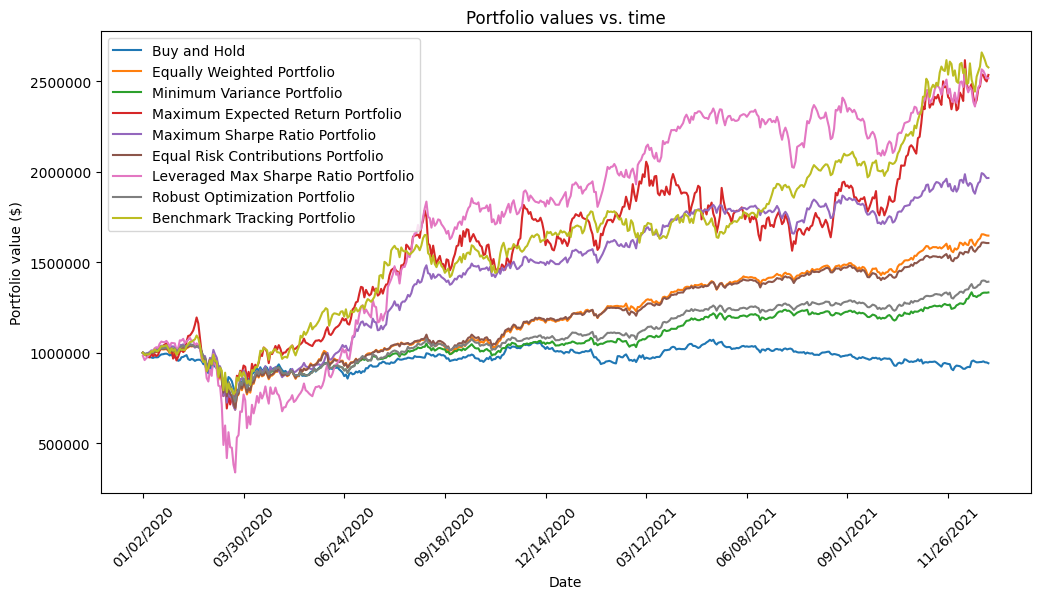

In [15]:
# Plot portfolio values for all strategies vs. time
plt.figure(figsize=(12, 6))
for strategy in range(N_strat):
    plt.plot(dates, portf_value[strategy], label=strategy_names[strategy])

plt.title('Portfolio values vs. time')
plt.xlabel('Date')
plt.ylabel('Portfolio value ($)')
plt.xticks(ticks=np.arange(0, len(dates), step=60), labels=dates[::60], rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show()

After implementing the strategies for the period 2020-2021, we plot the daily portfolio values. From the graph, we can see that the top three strategies that give us the highest cumulative return is benchmark tracking strategy, leveraged max Sharpe ratio strategy, and the maximum expected return strategy. Following is the maximum Sharpe ratio strategy, equally weighted strategy, equal risk contribution strategy, robust optimization strategy, minimum variance strategy and buy and hold strategy.

## Plot the maximum drawdown

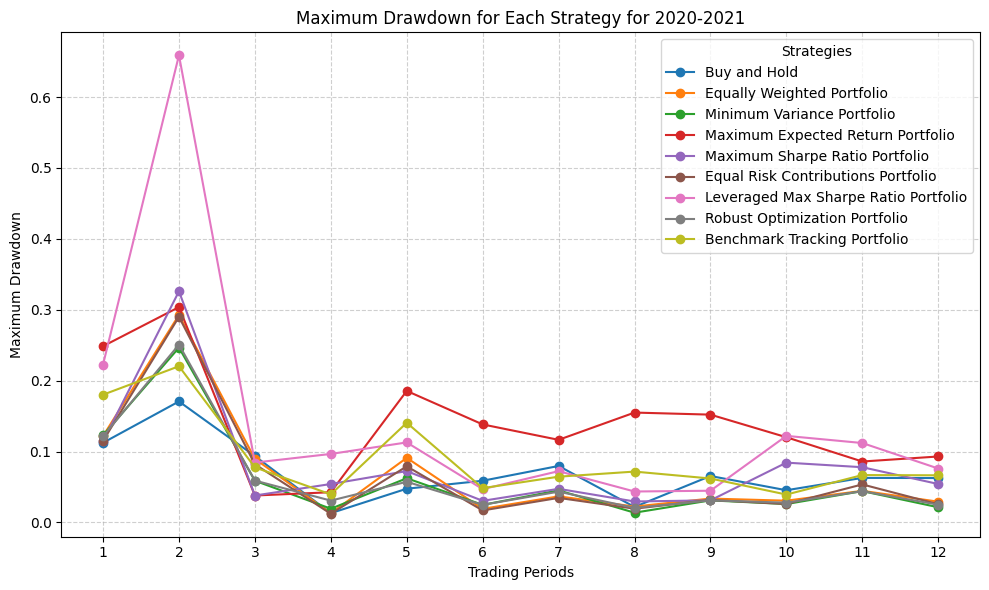

In [16]:
max_drawdowns = np.zeros((N_strat, N_periods))
for period in range(1, N_periods+1):
    for strategy in range(N_strat):
        # Depending on what data/csv (i.e time period) uncomment code
        if dates_array[0, 0] == 20:
            cur_year  = 20 + math.floor(period/7)
        else:
            cur_year  = 2020 + math.floor(period/7)

        cur_month = 2*((period-1)%6) + 1
        day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
        day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
        portf_period = portf_value[strategy][day_ind_start:day_ind_end+1]
        
        if len(portf_period) > 0:
            portf_period = np.asarray(portf_period).flatten()
            peak = np.maximum.accumulate(portf_period)  # Rolling max values
            drawdown = (peak - portf_period) / peak  # Compute drawdowns
            max_drawdowns[strategy, period - 1] = np.max(drawdown)  # Get max drawdown
# Convert to DataFrame for visualization
max_drawdowns_df = pd.DataFrame(
    max_drawdowns, index=strategy_names, columns=[f"Period {i+1}" for i in range(N_periods)]
)

# Plot the maximum drawdowns
plt.figure(figsize=(10, 6))
periods = np.arange(1, N_periods + 1)
for strategy in range(N_strat):
    plt.plot(periods, max_drawdowns[strategy, :], marker="o", label=strategy_names[strategy])

plt.xlabel("Trading Periods")
plt.ylabel("Maximum Drawdown")
plt.title("Maximum Drawdown for Each Strategy for 2020-2021")
plt.xticks(periods)
plt.legend(title="Strategies")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()                    

Then we plot the maximum drawdown of our portfolio for each of the 12 period from 2020 to 2021. We can see from the graph that most strategies have the same pattern in their maximum drawdown, where they spike in the second period and then drop in the third period. Later they fluctuate between 0 to 0.1. The leverage max Sharpe ratio strategy has the highest maximum drawdown among all at period 2, at about 0.6.

## Plot the dynamic change

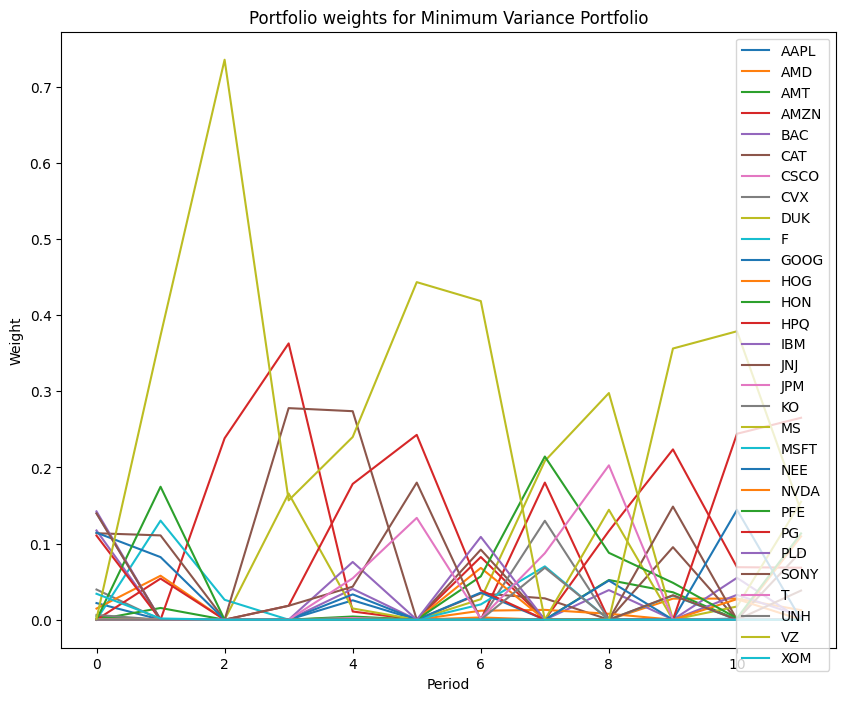

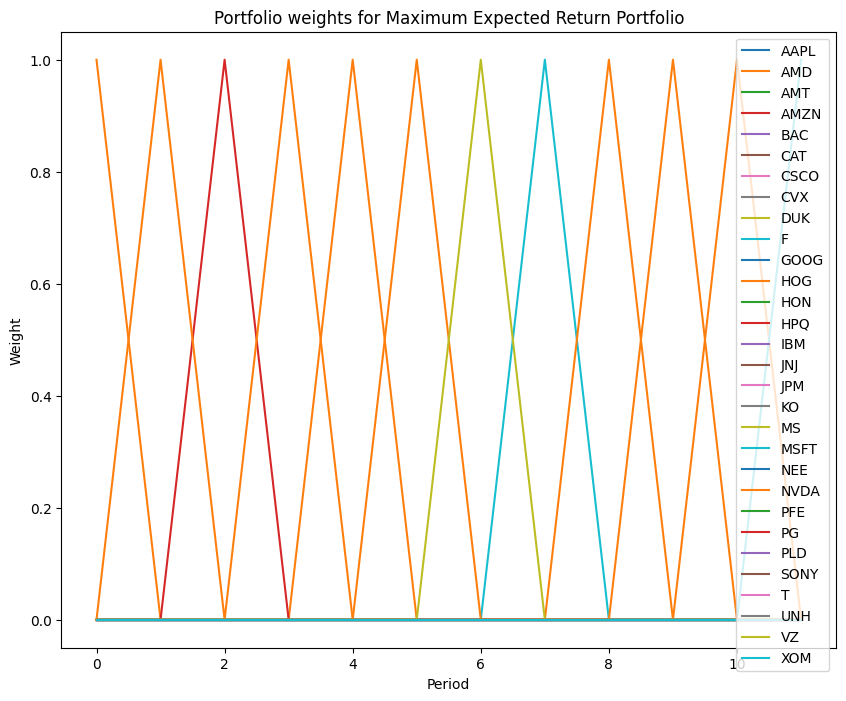

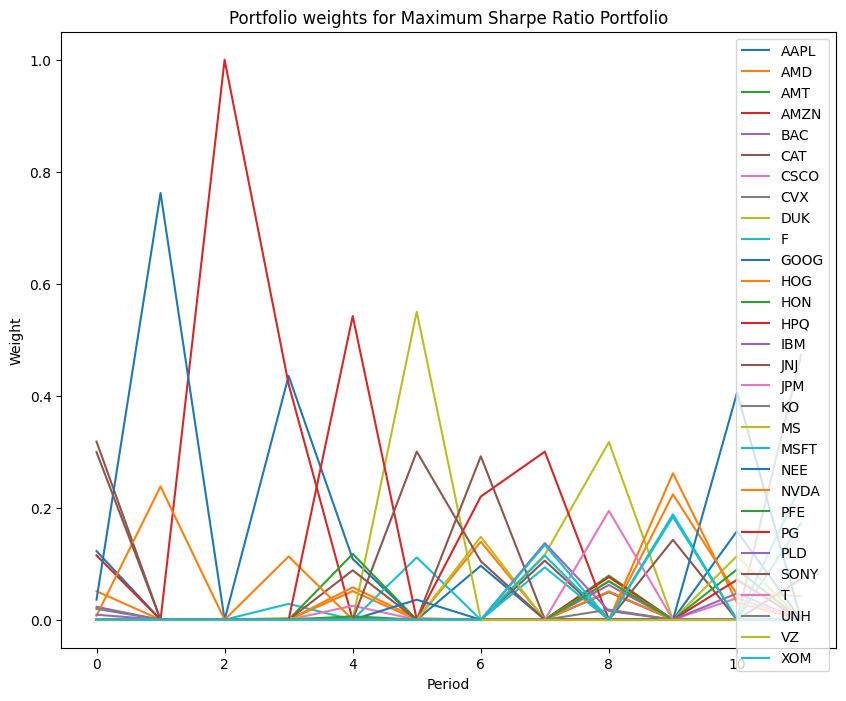

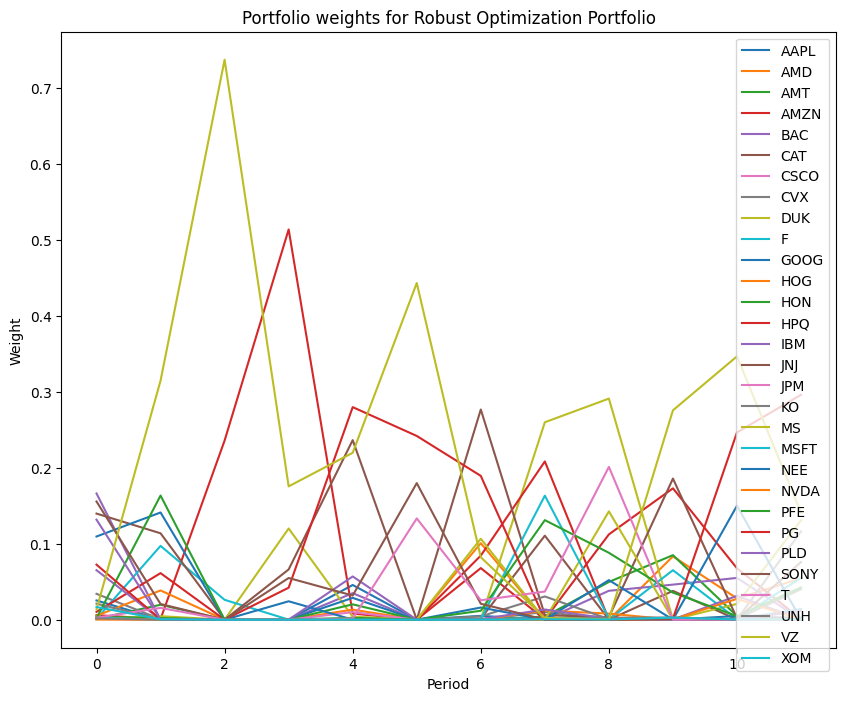

In [17]:
stocks = df.columns[1:]
strategies = [2, 3, 4, 7]
strategy_names = ['Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Robust Optimization Portfolio']

for strategy in strategies:
    weights = weight[strategy]
    plt.figure(figsize=(10, 8))
    for i in range(len(stocks)):
        plt.plot([w[i] for w in weights], label=stocks[i])
    plt.title(f'Portfolio weights for {strategy_names[strategies.index(strategy)]}')
    plt.xlabel('Period')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()

## Comparison between strategies

In [18]:
rf = r_rf

# Compute daily returns for each strategy
daily_returns = np.zeros((N_strat, N_days-1))
for strategy in range(N_strat):
    daily_portfolio_values = np.asarray(portf_value[strategy]).flatten()  # flatten to 1D array
    daily_returns[strategy] = daily_portfolio_values[1:] / daily_portfolio_values[:-1] - 1

# Compute the variance of daily returns for each strategy
daily_returns_variance = np.var(daily_returns, axis=1) * 252 # annualize the variance
daily_returns_variance

# Compute the maximum drawdown for each strategy
max_drawdowns = np.zeros(N_strat)
for strategy in range(N_strat):
    daily_portfolio_values = np.asarray(portf_value[strategy]).flatten()  # flatten to 1D array
    cum_returns = daily_portfolio_values / daily_portfolio_values[0] - 1
    max_drawdowns[strategy] = np.max(np.maximum.accumulate(cum_returns) - cum_returns)

# compute the sharpe ratio for each strategy
sharpe_ratios = np.zeros(N_strat)
for strategy in range(N_strat):
    daily_portfolio_values = np.asarray(portf_value[strategy]).flatten()  # flatten to 1D array
    daily_returns = daily_portfolio_values[1:] / daily_portfolio_values[:-1] - 1
    sharpe_ratios[strategy] = np.sqrt(252) * (np.mean(daily_returns) - rf/252) / np.std(daily_returns) # annualize the sharpe ratio

# compute the cumulative return for each strategy
cumulative_returns = np.zeros(N_strat)
for strategy in range(N_strat):
    daily_portfolio_values = np.asarray(portf_value[strategy]).flatten()  # flatten to 1D array
    cumulative_returns[strategy] = daily_portfolio_values[-1] / daily_portfolio_values[0] - 1

# print the results as a table
strategy_names = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio', 'Benchmark Tracking Portfolio']
results_20_21 = pd.DataFrame({
    'Strategy': strategy_names,
    'Variance': daily_returns_variance,
    'Maximum Drawdown': max_drawdowns,
    'Sharpe Ratio': sharpe_ratios,
    'Cumulative Return': cumulative_returns
})
# expand the display width
pd.set_option('display.width', 1000)

print(results_20_21)

                               Strategy  Variance  Maximum Drawdown  Sharpe Ratio  Cumulative Return
0                          Buy and Hold  0.042237          0.215932     -0.114380          -0.057414
1            Equally Weighted Portfolio  0.069555          0.355112      1.023210           0.647990
2            Minimum Variance Portfolio  0.043426          0.313834      0.724116           0.333960
3     Maximum Expected Return Portfolio  0.217997          0.502945      1.199656           1.535859
4        Maximum Sharpe Ratio Portfolio  0.095279          0.364702      1.201736           0.966356
5    Equal Risk Contributions Portfolio  0.061910          0.344387      1.018274           0.606871
6  Leveraged Max Sharpe Ratio Portfolio  0.620965          0.756753      0.953773           1.562143
7         Robust Optimization Portfolio  0.046649          0.313028      0.806760           0.393229
8          Benchmark Tracking Portfolio  0.125027          0.323674      1.474788          

# Question 3: Test your trading strategies for years 2008 and 2009

In [19]:
# Input file
input_file_prices = 'adjclose_2008_2009.csv' # path to close_2008_2009 

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [20]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2007 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
#day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])   # for 2020-2021 csv

day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])   # for 2008-2009 csv
#day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])   # for 2022 csv

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2007
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19385, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 1.5%
r_rf = 0.015
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

# Weights of assets in the benchmark portfolio S&P30 for years 2020-2021
w_b = np.array([0.14832533, 0.15556291, 0.01990254, 0.05079846, 0.01302685, 0.01030985, 0.02252249, 0.00227124, 0.01039192, 0.04658236, 0.03283954, 0.00969637, 0.04241193, 0.03487371, 0.02320889, 0.13583777, 0.00402455, 0.0006036 , 0.02832933, 0.03569527, 0.03306551, 0.02349243, 0.01306872, 0.01004722, 0.01983845, 0.02674073, 0.01439791, 0.00883091, 0.01532609, 0.00797711])
# Weights of assets in the benchmark portfolio S&P30 for years 2008-2009
w_b2008_2009 = np.array([0.04515391, 0.09628167, 0.00962156, 0.04751553, 0.02738386, 0.00612178, 0.03599232, 0.00710205, 0.02258147, 0.03947036, 0.11549755, 0.02968896, 0.04899179, 0.02151471, 0.03012594, 0.02472594, 0.00728987, 0.00204819, 0.03935471, 0.052657, 0.11181873, 0.04252905, 0.00758877, 0.01545498, 0.03195875, 0.03585342, 0.01304049, 0.01117294, 0.01060861, 0.01085508])
# Weights of assets in the benchmark portfolio S&P30 for year 2022
w_b2022 = np.array([0.1994311, 0.18518391, 0.05464191, 0.06021769, 0.00822679, 0.01771958, 0.01735487, 0.00242781, 0.0111223 , 0.03079034, 0.02378042, 0.01075559, 0.02868988, 0.03363043, 0.02184145, 0.13425809, 0.00503211, 0.00034546, 0.0177085 , 0.02689907, 0.01820472, 0.0139343 , 0.00946646, 0.01088172, 0.00821592, 0.01352356, 0.00966943, 0.00712117, 0.01347266, 0.00545276])

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_return', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_max_Sharpe', 'strat_robust_optim', 'strat_tracking_index']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio', 'Benchmark Tracking Portfolio']
# N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_return, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_max_Sharpe, strat_robust_optim, strat_tracking_index]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period

   # Depending on what data/csv (i.e time period) uncomment code
   #if dates_array[0, 0] == 20:
   #    cur_year  = 20 + math.floor(period/7)
   #else:
   #    cur_year  = 2020 + math.floor(period/7)

   # example for 2008-2009 data
   if dates_array[0, 0] == 8:
      cur_year  = 8 + math.floor(period/7)
   else:
      cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices, r_rf2008_2009, w_b2008_2009)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs
      while cash[strategy, period-1] < 0:
         deficit = abs(cash[strategy, period-1])
         portfolio_value = curr_cash + np.dot(cur_prices, curr_positions)
         weights = weight[strategy, period-1]
         sell_amounts = np.ceil((weights * deficit) / cur_prices).astype(int)
         # only subtract the sell_amounts from those assets that are not 0 in x_optimal
         sell_amounts = np.minimum(sell_amounts, x[strategy, period-1])*2
         x[strategy, period-1] -= sell_amounts
         trade_costs = np.dot(cur_prices, abs(sell_amounts)) * 0.005
         cash[strategy, period-1] = portfolio_value - np.dot(cur_prices, x[strategy, period-1]) - trade_costs

      
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      if strategy == 6:
         portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - borrowed
      else:
         portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format( strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0], cash[strategy, period-1]))


   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 431667.19


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 431667.19, value end = $ 362791.58, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 431626.92, value end = $ 384944.91, cash account = $8407.71
  Strategy "Minimum Variance Portfolio", value begin = $ 431623.84, value end = $ 400203.15, cash account = $8755.96
  Strategy "Maximum Expected Return Portfolio", value begin = $ 431624.25, value end = $ 355553.99, cash account = $8572.65
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 431624.46, value end = $ 354957.45, cash account = $8576.22
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 431627.00, value end = $ 389608.98, cash account = $8348.99
  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ 422051.04, value end = $ 269089.47, cash account = $9656.99
  Strategy "Robust Optimization Portfolio", value begin = $ 431624.40, valu

## Plot the daily value

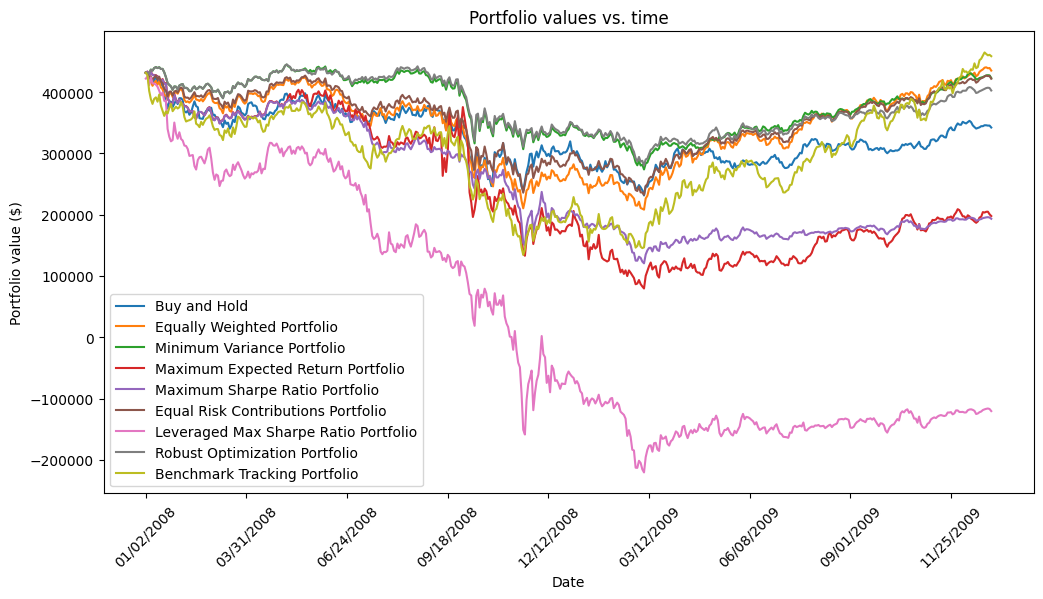

In [21]:
# Plot portfolio values for all strategies vs. time
plt.figure(figsize=(12, 6))
for strategy in range(N_strat):
    plt.plot(dates, portf_value[strategy], label=strategy_names[strategy])

plt.title('Portfolio values vs. time')
plt.xlabel('Date')
plt.ylabel('Portfolio value ($)')
plt.xticks(ticks=np.arange(0, len(dates), step=60), labels=dates[::60], rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show()

## Plot the maximum drawdown

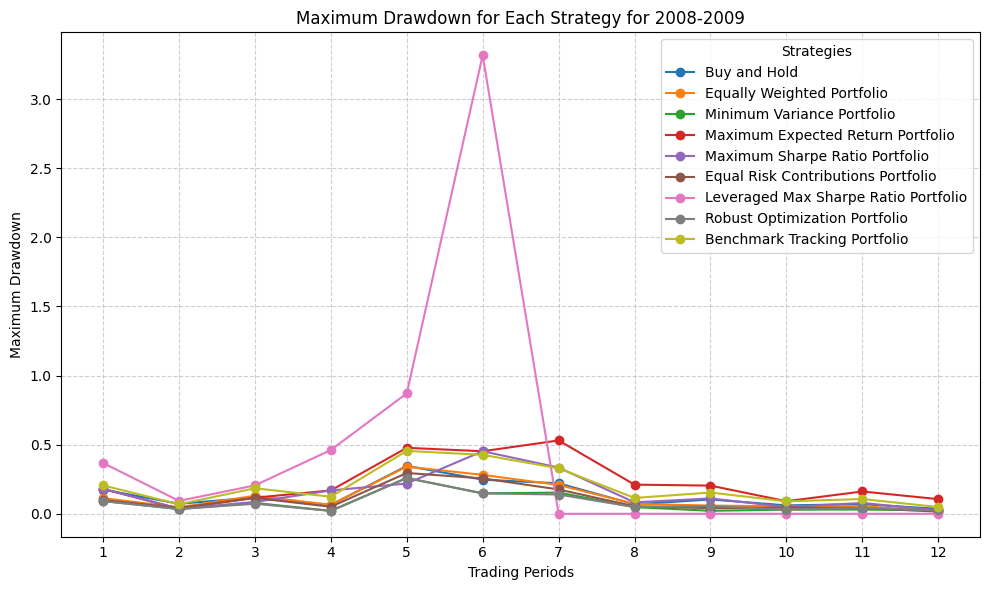

In [22]:
max_drawdowns = np.zeros((N_strat, N_periods))
for period in range(1, N_periods+1):
    for strategy in range(N_strat):
        # Depending on what data/csv (i.e time period) uncomment code
        if dates_array[0, 0] == 8:
            cur_year  = 8 + math.floor(period/7)
        else:
            cur_year  = 2008 + math.floor(period/7)

        cur_month = 2*((period-1)%6) + 1
        day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
        day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
        portf_period = portf_value[strategy][day_ind_start:day_ind_end+1]
        
        if len(portf_period) > 0:
            portf_period = np.asarray(portf_period).flatten()
            peak = np.maximum.accumulate(portf_period)  # Rolling max values
            drawdown = (peak - portf_period) / peak  # Compute drawdowns
            max_drawdowns[strategy, period - 1] = np.max(drawdown)  # Get max drawdown
# Convert to DataFrame for visualization
max_drawdowns_df = pd.DataFrame(
    max_drawdowns, index=strategy_names, columns=[f"Period {i+1}" for i in range(N_periods)]
)

# Plot the maximum drawdowns
plt.figure(figsize=(10, 6))
periods = np.arange(1, N_periods + 1)
for strategy in range(N_strat):
    plt.plot(periods, max_drawdowns[strategy, :], marker="o", label=strategy_names[strategy])

plt.xlabel("Trading Periods")
plt.ylabel("Maximum Drawdown")
plt.title("Maximum Drawdown for Each Strategy for 2008-2009")
plt.xticks(periods)
plt.legend(title="Strategies")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()                    

## Plot the dynamic change

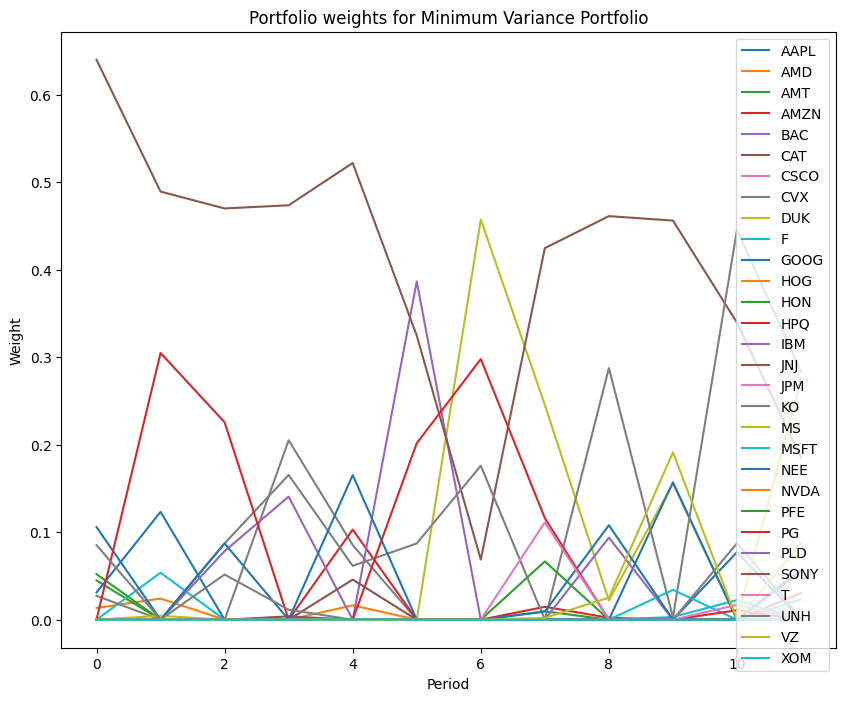

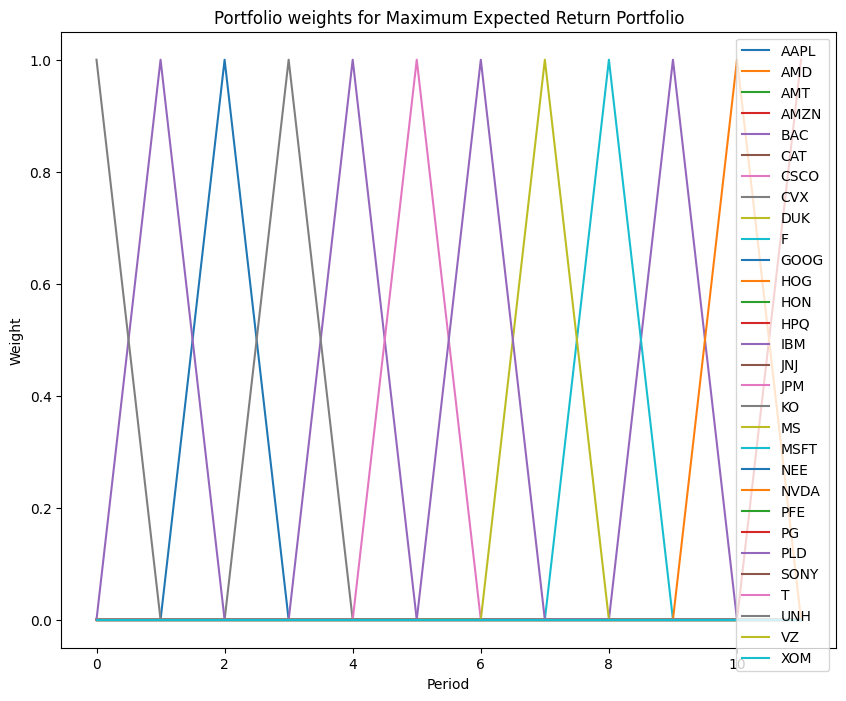

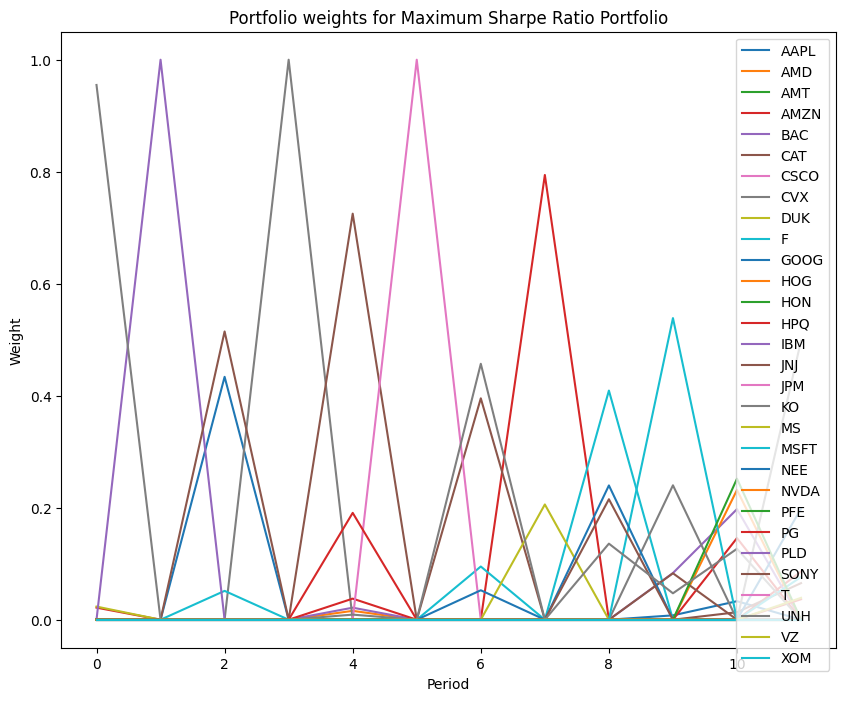

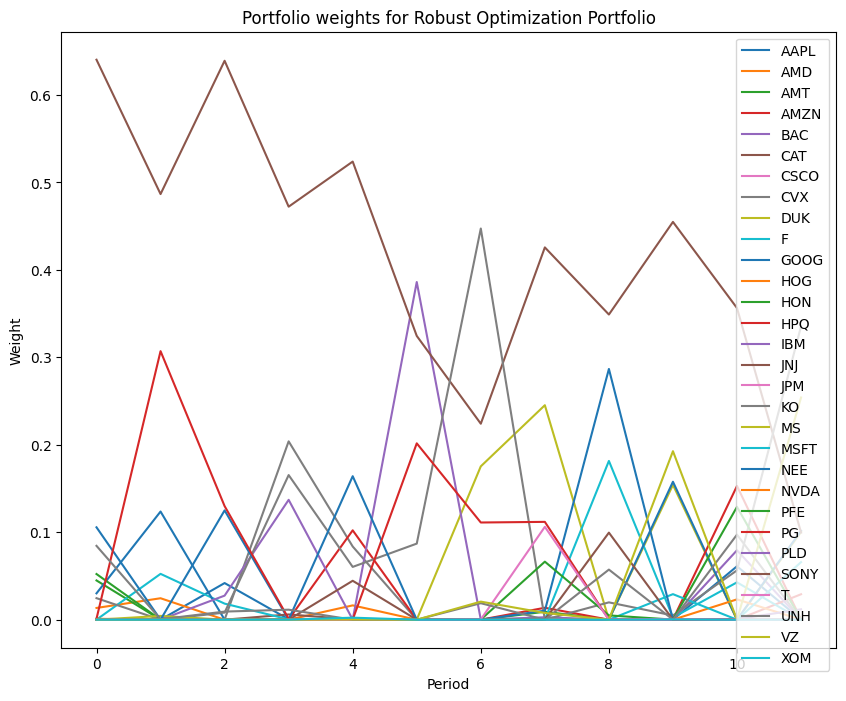

In [23]:
stocks = df.columns[1:]
strategies = [2, 3, 4, 7]
strategy_names = ['Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Robust Optimization Portfolio']

for strategy in strategies:
    weights = weight[strategy]
    plt.figure(figsize=(10, 8))
    for i in range(len(stocks)):
        plt.plot([w[i] for w in weights], label=stocks[i])
    plt.title(f'Portfolio weights for {strategy_names[strategies.index(strategy)]}')
    plt.xlabel('Period')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()

## Comparison between strategies

In [24]:
rf = r_rf2008_2009

# Compute daily returns for each strategy
daily_returns = np.zeros((N_strat, N_days-1))
for strategy in range(N_strat):
    daily_portfolio_values = np.asarray(portf_value[strategy]).flatten()  # flatten to 1D array
    daily_returns[strategy] = daily_portfolio_values[1:] / daily_portfolio_values[:-1] - 1

# Compute the variance of daily returns for each strategy
daily_returns_variance = np.var(daily_returns, axis=1) * 252 # annualize the variance
daily_returns_variance

# Compute the maximum drawdown for each strategy
max_drawdowns = np.zeros(N_strat)
for strategy in range(N_strat):
    daily_portfolio_values = np.asarray(portf_value[strategy]).flatten()  # flatten to 1D array
    cum_returns = daily_portfolio_values / daily_portfolio_values[0] - 1
    max_drawdowns[strategy] = np.max(np.maximum.accumulate(cum_returns) - cum_returns)

# compute the sharpe ratio for each strategy
sharpe_ratios = np.zeros(N_strat)
for strategy in range(N_strat):
    daily_portfolio_values = np.asarray(portf_value[strategy]).flatten()  # flatten to 1D array
    daily_returns = daily_portfolio_values[1:] / daily_portfolio_values[:-1] - 1
    sharpe_ratios[strategy] = np.sqrt(252) * (np.mean(daily_returns) - rf/252) / np.std(daily_returns) # annualize the sharpe ratio

# compute the cumulative return for each strategy
cumulative_returns = np.zeros(N_strat)
for strategy in range(N_strat):
    daily_portfolio_values = np.asarray(portf_value[strategy]).flatten()  # flatten to 1D array
    cumulative_returns[strategy] = daily_portfolio_values[-1] / daily_portfolio_values[0] - 1

# print the results as a table
strategy_names = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio', 'Benchmark Tracking Portfolio']
results_08_09 = pd.DataFrame({
    'Strategy': strategy_names,
    'Variance': daily_returns_variance,
    'Maximum Drawdown': max_drawdowns,
    'Sharpe Ratio': sharpe_ratios,
    'Cumulative Return': cumulative_returns
})
# expand the display width
pd.set_option('display.width', 1000)

print(results_08_09)

                               Strategy    Variance  Maximum Drawdown  Sharpe Ratio  Cumulative Return
0                          Buy and Hold    0.135873          0.464937     -0.253344          -0.207130
1            Equally Weighted Portfolio    0.148608          0.517376      0.085853           0.008145
2            Minimum Variance Portfolio    0.065398          0.396006     -0.088642          -0.019913
3     Maximum Expected Return Portfolio    0.662431          0.819863     -0.123367          -0.541534
4        Maximum Sharpe Ratio Portfolio    0.219314          0.724405     -0.717375          -0.551911
5    Equal Risk Contributions Portfolio    0.110619          0.461401     -0.004240          -0.022648
6  Leveraged Max Sharpe Ratio Portfolio  905.640530          1.530463     -0.941136          -1.284960
7         Robust Optimization Portfolio    0.068608          0.382876     -0.174718          -0.067151
8          Benchmark Tracking Portfolio    0.355872          0.688500    

# Question 4: Test your trading strategies for year 2022

In [25]:
# Input file
input_file_prices = 'adjclose_2022.csv' # path to close_2022

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [26]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2021 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
#day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])   # for 2020-2021 csv

#day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])   # for 2008-2009 csv
day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])   # for 2022 csv

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2021
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19385, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 1.5%
r_rf = 0.015
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

# Weights of assets in the benchmark portfolio S&P30 for years 2020-2021
w_b = np.array([0.14832533, 0.15556291, 0.01990254, 0.05079846, 0.01302685, 0.01030985, 0.02252249, 0.00227124, 0.01039192, 0.04658236, 0.03283954, 0.00969637, 0.04241193, 0.03487371, 0.02320889, 0.13583777, 0.00402455, 0.0006036 , 0.02832933, 0.03569527, 0.03306551, 0.02349243, 0.01306872, 0.01004722, 0.01983845, 0.02674073, 0.01439791, 0.00883091, 0.01532609, 0.00797711])
# Weights of assets in the benchmark portfolio S&P30 for years 2008-2009
w_b2008_2009 = np.array([0.04515391, 0.09628167, 0.00962156, 0.04751553, 0.02738386, 0.00612178, 0.03599232, 0.00710205, 0.02258147, 0.03947036, 0.11549755, 0.02968896, 0.04899179, 0.02151471, 0.03012594, 0.02472594, 0.00728987, 0.00204819, 0.03935471, 0.052657, 0.11181873, 0.04252905, 0.00758877, 0.01545498, 0.03195875, 0.03585342, 0.01304049, 0.01117294, 0.01060861, 0.01085508])
# Weights of assets in the benchmark portfolio S&P30 for year 2022
w_b2022 = np.array([0.1994311, 0.18518391, 0.05464191, 0.06021769, 0.00822679, 0.01771958, 0.01735487, 0.00242781, 0.0111223 , 0.03079034, 0.02378042, 0.01075559, 0.02868988, 0.03363043, 0.02184145, 0.13425809, 0.00503211, 0.00034546, 0.0177085 , 0.02689907, 0.01820472, 0.0139343 , 0.00946646, 0.01088172, 0.00821592, 0.01352356, 0.00966943, 0.00712117, 0.01347266, 0.00545276])

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_return', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_max_Sharpe', 'strat_robust_optim', 'strat_tracking_index']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio', 'Benchmark Tracking Portfolio']
# N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_return, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_max_Sharpe, strat_robust_optim, strat_tracking_index]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period

   # Depending on what data/csv (i.e time period) uncomment code
   #if dates_array[0, 0] == 20:
   #    cur_year  = 20 + math.floor(period/7)
   #else:
   #    cur_year  = 2020 + math.floor(period/7)

   # example for 2022 data
   if dates_array[0, 0] == 22:
      cur_year  = 22 + math.floor(period/7)
   else:
      cur_year  = 2022 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices, r_rf2022, w_b2022)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs
      while cash[strategy, period-1] < 0:
         deficit = abs(cash[strategy, period-1])
         portfolio_value = curr_cash + np.dot(cur_prices, curr_positions)
         weights = weight[strategy, period-1]
         sell_amounts = np.ceil((weights * deficit) / cur_prices).astype(int)
         # only subtract the sell_amounts from those assets that are not 0 in x_optimal
         sell_amounts = np.minimum(sell_amounts, x[strategy, period-1])*2         
         x[strategy, period-1] -= sell_amounts
         trade_costs = np.dot(cur_prices, abs(sell_amounts)) * 0.005
         cash[strategy, period-1] = portfolio_value - np.dot(cur_prices, x[strategy, period-1]) - trade_costs

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      if strategy == 6:
         portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - borrowed
      else:
         portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format( strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0], cash[strategy, period-1]))


   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 950205.84


Period 1: start date 01/03/2022, end date 02/28/2022
  Strategy "Buy and Hold", value begin = $ 950205.84, value end = $ 992093.09, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 950118.10, value end = $ 888361.13, cash account = $19296.25
  Strategy "Minimum Variance Portfolio", value begin = $ 950145.68, value end = $ 916449.86, cash account = $12960.66
  Strategy "Maximum Expected Return Portfolio", value begin = $ 950110.96, value end = $ 796369.77, cash account = $18930.16
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 950113.64, value end = $ 870374.05, cash account = $18916.58
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 950124.01, value end = $ 888490.39, cash account = $18185.96
  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ 930209.37, value end = $ 770780.36, cash account = $19083.68
  Strategy "Robust Optimization Portfolio", value begin = $ 950129.26

## Plot the daily value

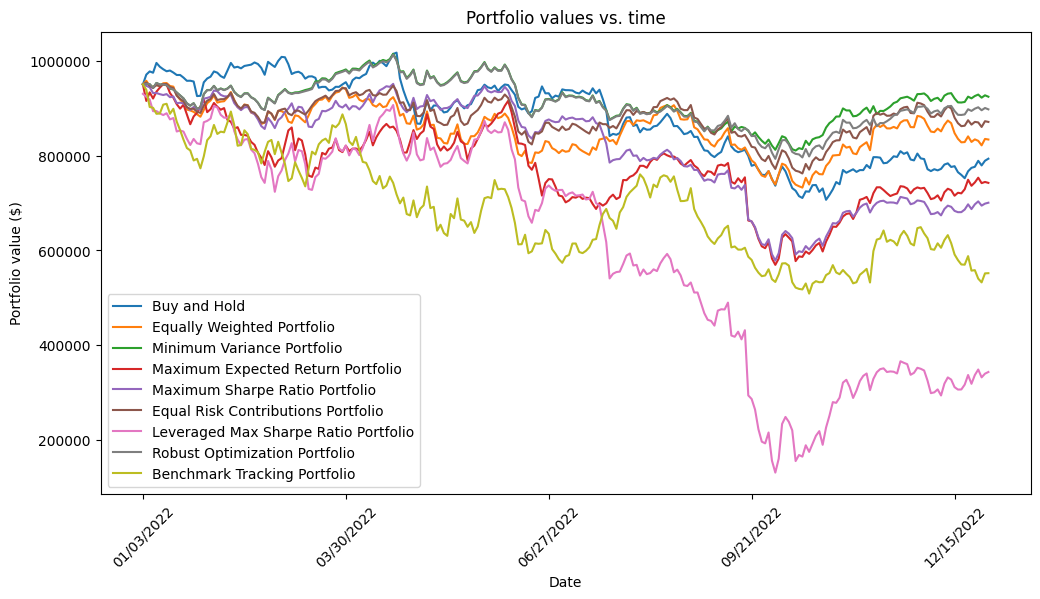

In [27]:
# Plot portfolio values for all strategies vs. time
plt.figure(figsize=(12, 6))
for strategy in range(N_strat):
    plt.plot(dates, portf_value[strategy], label=strategy_names[strategy])

plt.title('Portfolio values vs. time')
plt.xlabel('Date')
plt.ylabel('Portfolio value ($)')
plt.xticks(ticks=np.arange(0, len(dates), step=60), labels=dates[::60], rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show()

## Plot the maximum drawdown

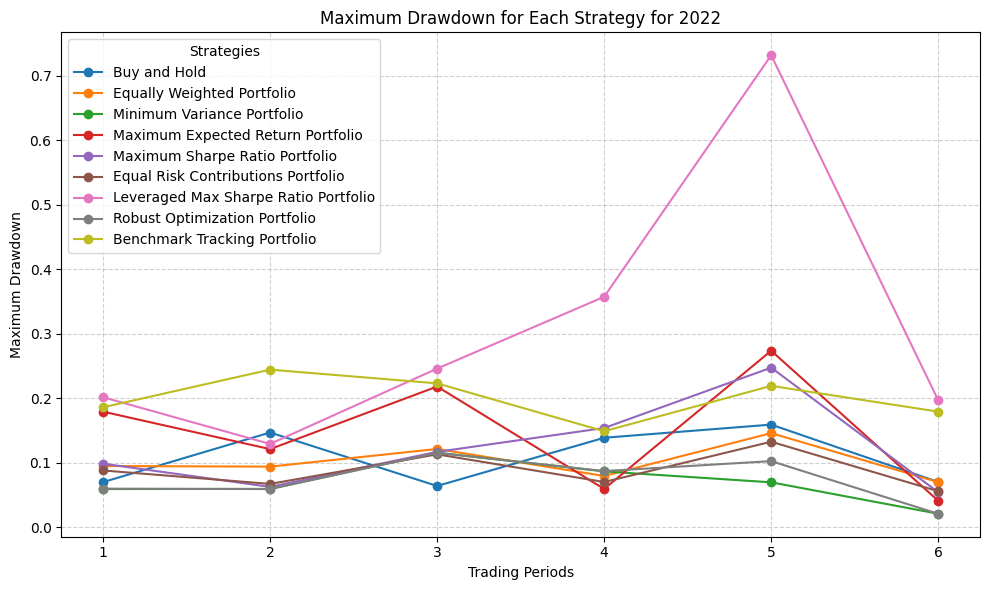

In [28]:
max_drawdowns = np.zeros((N_strat, N_periods))
for period in range(1, N_periods+1):
    for strategy in range(N_strat):
        # Depending on what data/csv (i.e time period) uncomment code
        if dates_array[0, 0] == 22:
            cur_year  = 22 + math.floor(period/7)
        else:
            cur_year  = 2022 + math.floor(period/7)

        cur_month = 2*((period-1)%6) + 1
        day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
        day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
        portf_period = portf_value[strategy][day_ind_start:day_ind_end+1]
        
        if len(portf_period) > 0:
            portf_period = np.asarray(portf_period).flatten()
            peak = np.maximum.accumulate(portf_period)  # Rolling max values
            drawdown = (peak - portf_period) / peak  # Compute drawdowns
            max_drawdowns[strategy, period - 1] = np.max(drawdown)  # Get max drawdown
# Convert to DataFrame for visualization
max_drawdowns_df = pd.DataFrame(
    max_drawdowns, index=strategy_names, columns=[f"Period {i+1}" for i in range(N_periods)]
)

# Plot the maximum drawdowns
plt.figure(figsize=(10, 6))
periods = np.arange(1, N_periods + 1)
for strategy in range(N_strat):
    plt.plot(periods, max_drawdowns[strategy, :], marker="o", label=strategy_names[strategy])

plt.xlabel("Trading Periods")
plt.ylabel("Maximum Drawdown")
plt.title("Maximum Drawdown for Each Strategy for 2022")
plt.xticks(periods)
plt.legend(title="Strategies")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()                    

## Plot the dynamic change

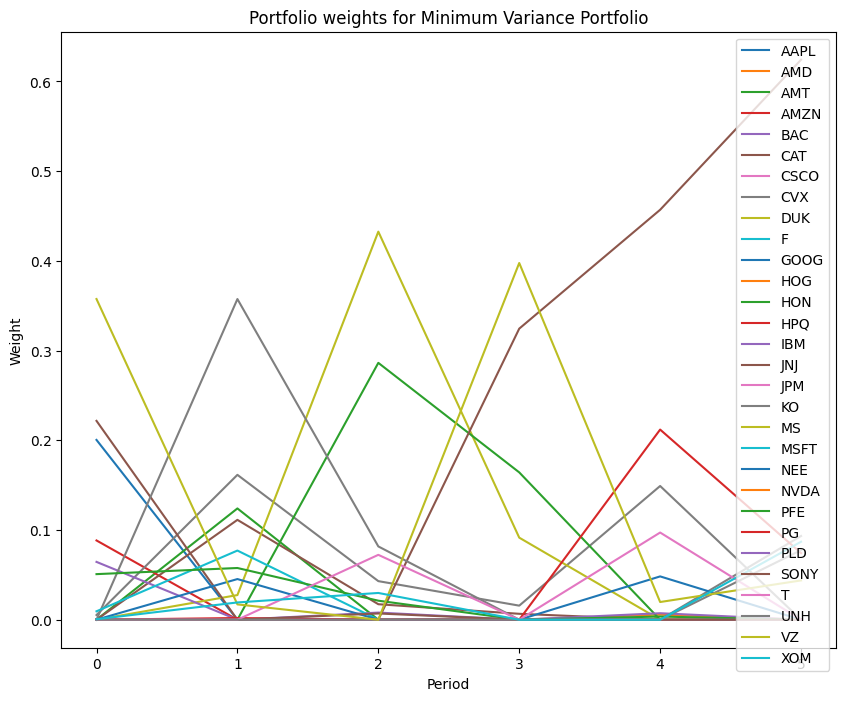

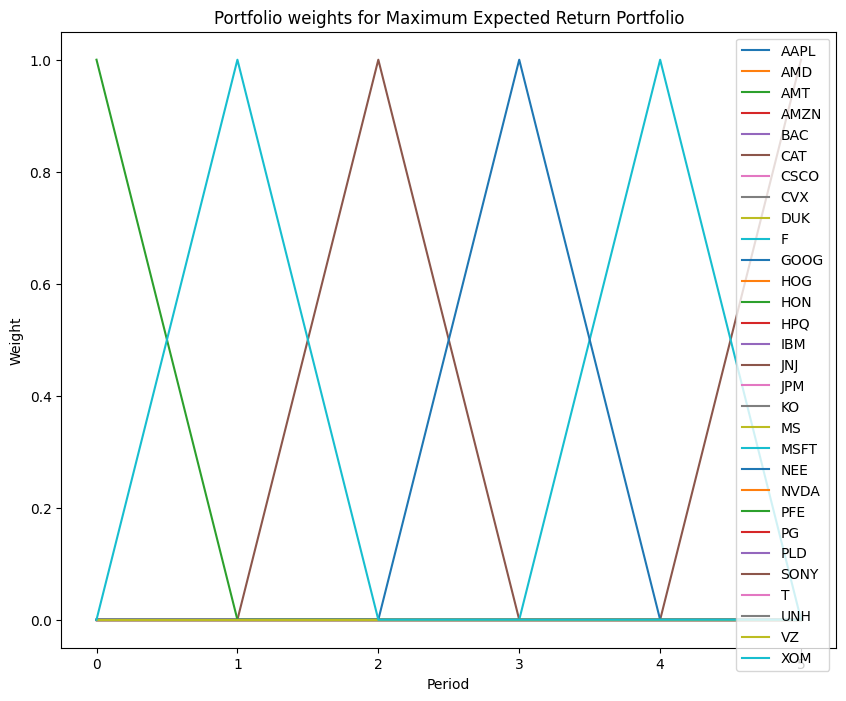

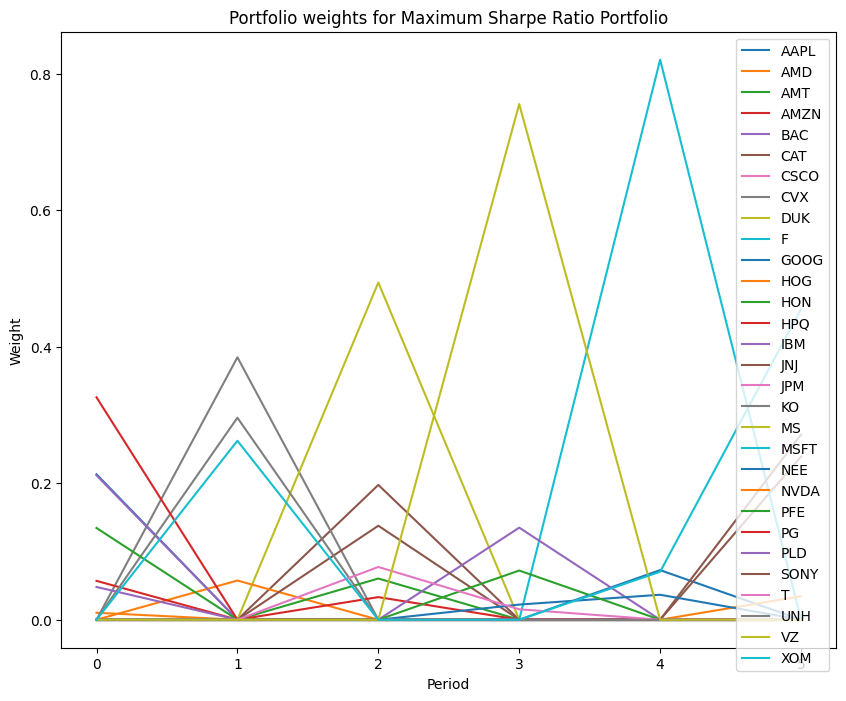

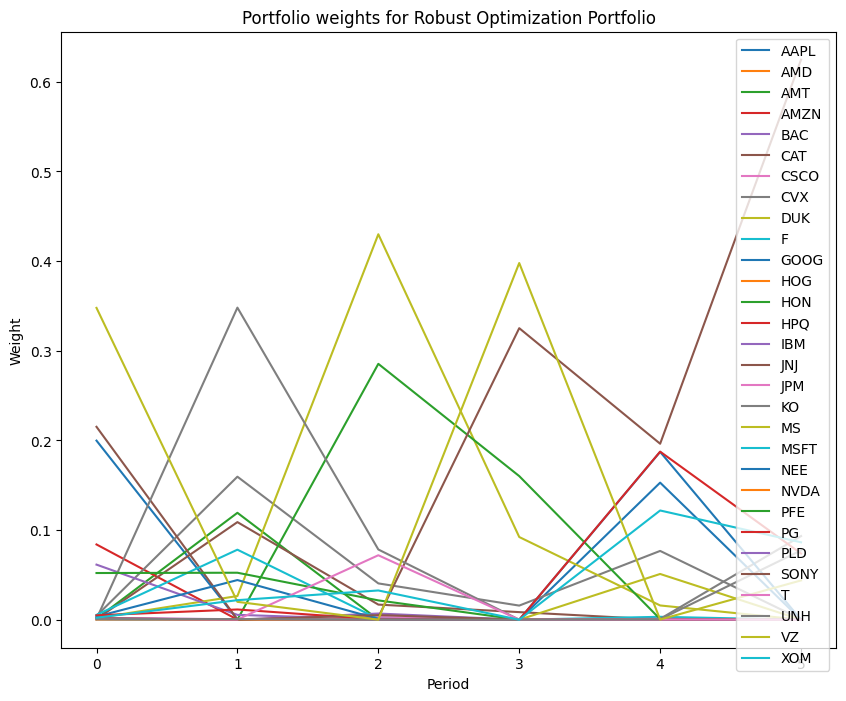

In [29]:
stocks = df.columns[1:]
strategies = [2, 3, 4, 7]
strategy_names = ['Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Robust Optimization Portfolio']

for strategy in strategies:
    weights = weight[strategy]
    plt.figure(figsize=(10, 8))
    for i in range(len(stocks)):
        plt.plot([w[i] for w in weights], label=stocks[i])
    plt.title(f'Portfolio weights for {strategy_names[strategies.index(strategy)]}')
    plt.xlabel('Period')
    plt.ylabel('Weight')
    plt.legend(loc='upper right')
    plt.show()

## Comparison between strategies

In [30]:
rf = r_rf2022

# Compute daily returns for each strategy
daily_returns = np.zeros((N_strat, N_days-1))
for strategy in range(N_strat):
    daily_portfolio_values = np.asarray(portf_value[strategy]).flatten()  # flatten to 1D array
    daily_returns[strategy] = daily_portfolio_values[1:] / daily_portfolio_values[:-1] - 1

# Compute the variance of daily returns for each strategy
daily_returns_variance = np.var(daily_returns, axis=1) * 252 # annualize the variance
daily_returns_variance

# Compute the maximum drawdown for each strategy
max_drawdowns = np.zeros(N_strat)
for strategy in range(N_strat):
    daily_portfolio_values = np.asarray(portf_value[strategy]).flatten()  # flatten to 1D array
    cum_returns = daily_portfolio_values / daily_portfolio_values[0] - 1
    max_drawdowns[strategy] = np.max(np.maximum.accumulate(cum_returns) - cum_returns)

# compute the sharpe ratio for each strategy
sharpe_ratios = np.zeros(N_strat)
for strategy in range(N_strat):
    daily_portfolio_values = np.asarray(portf_value[strategy]).flatten()  # flatten to 1D array
    daily_returns = daily_portfolio_values[1:] / daily_portfolio_values[:-1] - 1
    sharpe_ratios[strategy] = np.sqrt(252) * (np.mean(daily_returns) - rf/252) / np.std(daily_returns) # annualize the sharpe ratio

# compute the cumulative return for each strategy
cumulative_returns = np.zeros(N_strat)
for strategy in range(N_strat):
    daily_portfolio_values = np.asarray(portf_value[strategy]).flatten()  # flatten to 1D array
    cumulative_returns[strategy] = daily_portfolio_values[-1] / daily_portfolio_values[0] - 1

# print the results as a table
strategy_names = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio', 'Benchmark Tracking Portfolio']
results_2022 = pd.DataFrame({
    'Strategy': strategy_names,
    'Variance': daily_returns_variance,
    'Maximum Drawdown': max_drawdowns,
    'Sharpe Ratio': sharpe_ratios,
    'Cumulative Return': cumulative_returns
})
# expand the display width
pd.set_option('display.width', 1000)

print(results_2022)

                               Strategy  Variance  Maximum Drawdown  Sharpe Ratio  Cumulative Return
0                          Buy and Hold  0.048412          0.326731     -0.885479          -0.164966
1            Equally Weighted Portfolio  0.051852          0.237199     -0.628203          -0.122309
2            Minimum Variance Portfolio  0.024332          0.214890     -0.341330          -0.027314
3     Maximum Expected Return Portfolio  0.116404          0.401252     -0.665058          -0.218556
4        Maximum Sharpe Ratio Portfolio  0.061383          0.392294     -1.264431          -0.262616
5    Equal Risk Contributions Portfolio  0.038631          0.201814     -0.538291          -0.083262
6  Leveraged Max Sharpe Ratio Portfolio  1.021083          0.858799     -0.516170          -0.630672
7         Robust Optimization Portfolio  0.027316          0.231327     -0.491319          -0.055320
8          Benchmark Tracking Portfolio  0.212477          0.464312     -1.037792          